In [ ]:
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
# 计算距离
def Span(data):
    R = 6371.393  # 地球半径，单位为千米  
    for i in range(1,len(data)):
        # A地  
        jingduA, weiduA = data.loc[i-1,['经度','纬度']]
        # B地  
        jingduB, weiduB = data.loc[i,['经度','纬度']]

        # 将经纬度转换为弧度  
        latA, lonA = math.radians(weiduA), math.radians(jingduA)  
        latB, lonB = math.radians(weiduB), math.radians(jingduB)  

        # 哈弗辛公式  
        dlat = latB - latA  
        dlon = lonB - lonA  
        a = math.sin(dlat/2)**2 + math.cos(latA) * math.cos(latB) * math.sin(dlon/2)**2  
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))  

        distance = R * c * 1000  # 距离，单位为米  
        # 转换为米  
        data['距离差'][i]=distance
    return data

In [3]:
# 定义一个函数来提取指定位置的字段内容
def extract_field(text, position):
    # 根据逗号分隔字符串
    fields = text.split(',')
    
    # 确保位置有效
    if position < len(fields):
        return fields[position]
    else:
        return None

In [4]:
# 假设 data 是一个 Pandas DataFrame，包含经纬度、速度、方向和运动状态的序列数据
# 数据集格式：[经度1, 纬度1, 速度1, 方向1, 运动状态1, 经度2, 纬度2, 速度2, 方向2, 运动状态2]
# data = pd.read_excel('D:/data/0280/0280_cut.xlsx')
# # 提取特征和标签
# # features = data[['定位时间','经度', '纬度', '活动状态', '定位状态', '方向','速度']].values
# # labels = data[['后经度', '后纬度']].values

# data['前活动状态'] = data['活动状态'].shift(+1)
# data['前定位方式'] = data['定位方式'].shift(+1)
# data['前方向'] = data['方向'].shift(+1)
# data['前速度'] = data['速度'].shift(+1)
# data['前经度'] = data['经度'].shift(+1)
# data['前纬度'] = data['纬度'].shift(+1)

# # print(data)

# # 计算两点间距
# data['距离差']=np.NaN
# data=Span(data)



####################################################################################
data = pd.read_excel('D:/data/399071350587_1/123.xlsx')


#将文字类型转换为数字类型
data['活动状态'] = data['设备状态'].apply(lambda x: extract_field(x, 6))
data['活动状态']=data['活动状态'].map({'静止状态':0,'运动状态':1})

data['定位方式'] = data['设备状态'].apply(lambda x: extract_field(x, 1))
data['定位方式']=data['定位方式'].map({'GPS有效定位':0,'GPS无效定位':1,'LBS':1})


data=data[['定位时间','经度','纬度','活动状态','定位方式','方向','速度']]
# print(data)

data['前活动状态'] = data['活动状态'].shift(+1)
data['前定位方式'] = data['定位方式'].shift(+1)
data['前方向'] = data['方向'].shift(+1)
data['前速度'] = data['速度'].shift(+1)
data['前经度'] = data['经度'].shift(+1)
data['前纬度'] = data['纬度'].shift(+1)

# 计算两点间距
data['距离差']=np.NaN
data=Span(data)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_38016\533212094.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['距离差'][i]=distance
C:\Users\Administrator\AppData\Local\Temp\ipykernel_38016\533212094.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['距离差'][i]=distance
C:\Users\Administrator\AppData\Local\Temp\ipykernel_38016\533212094.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['距离差'][i]=distance
C:\U

In [6]:
# 处理时间列
data['定位时间'] = pd.to_datetime(data['定位时间'])  # 确保时间列是datetime格式
data['时间差']=data['定位时间'].diff().dt.total_seconds() # 计算时间差
data['时间差']=data['时间差'].fillna(0).astype(int)#将时间差转换为以秒为单位的int类型
data['year'] = data['定位时间'].dt.year
data['month'] = data['定位时间'].dt.month
data['day'] = data['定位时间'].dt.day
data['hour'] = data['定位时间'].dt.hour
data['minute'] = data['定位时间'].dt.minute
data['second'] = data['定位时间'].dt.second

#计算加速度
#由 V=V0+at    a=(V-V0)/t
data['加速度']=(data['速度']-data['前速度'])/data['时间差']

data = data.dropna()  # 删除缺失值


# # 删除原时间列
data = data.drop(columns=['定位时间'])
# data.info()

In [7]:
#用0滤除掉时间差为0的点
data.replace([np.inf, -np.inf], 0 , inplace=True)
# data.info()

In [8]:
# data.corr()

In [9]:
# # 提取特征和标签    #,'前经度', '前纬度','前活动状态','前定位方式','前方向','前速度','距离差','时间差','加速度'
features = ['year', 'month', 'day', 'hour', 'minute', 'second', '方向', '活动状态', '定位方式' ,'速度','前经度', '前纬度','前活动状态','前定位方式','前方向','前速度','距离差','时间差','加速度']
labels = ['经度','纬度']

X = data[features].values
y = data[labels].values


# 归一化特征和标签
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)


# #数据标准化
# scaler_X = StandardScaler()
# scaler_X.fit(X)
# X_scaled = scaler_X.fit_transform(X)
# scaler_y = StandardScaler()
# scaler_y.fit(y)
# y_scaled = scaler_y.transform(y)


# 创建时间序列数据
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)
time_steps=1
X_seq, y_seq = create_dataset(X_scaled, y_scaled, time_steps)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
X_test.shape

(345, 1, 12)

In [10]:
# 转换为PyTorch张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [11]:
X_train_tensor.shape[2]

12

In [12]:
# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 使用最后一个时间步的输出
        return out

input_size = X_train_tensor.shape[2]
hidden_size = 256
num_layers = 1 # LSTM层数
output_size = y_train_tensor.shape[1]
dropout = 0.5

model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


E:\anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [13]:
# 训练模型
num_epochs = 600
train_losses = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.7f}')

Epoch [5/600], Loss: 0.0834986
Epoch [10/600], Loss: 0.0561144
Epoch [15/600], Loss: 0.0403373
Epoch [20/600], Loss: 0.0292411
Epoch [25/600], Loss: 0.0287640
Epoch [30/600], Loss: 0.0226249
Epoch [35/600], Loss: 0.0201443
Epoch [40/600], Loss: 0.0211411
Epoch [45/600], Loss: 0.0190021
Epoch [50/600], Loss: 0.0183241
Epoch [55/600], Loss: 0.0180677
Epoch [60/600], Loss: 0.0173503
Epoch [65/600], Loss: 0.0167374
Epoch [70/600], Loss: 0.0161938
Epoch [75/600], Loss: 0.0156500
Epoch [80/600], Loss: 0.0153410
Epoch [85/600], Loss: 0.0151825
Epoch [90/600], Loss: 0.0149876
Epoch [95/600], Loss: 0.0147811
Epoch [100/600], Loss: 0.0145989
Epoch [105/600], Loss: 0.0143998
Epoch [110/600], Loss: 0.0141547
Epoch [115/600], Loss: 0.0138626
Epoch [120/600], Loss: 0.0135115
Epoch [125/600], Loss: 0.0130810
Epoch [130/600], Loss: 0.0125574
Epoch [135/600], Loss: 0.0119335
Epoch [140/600], Loss: 0.0112063
Epoch [145/600], Loss: 0.0103898
Epoch [150/600], Loss: 0.0095059
Epoch [155/600], Loss: 0.00859

In [14]:
# 评估模型
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    loss = criterion(y_pred_tensor, y_test_tensor)
    print(f'Test Loss: {loss.item():.7f}')

# 反归一化预测结果
y_pred = scaler_y.inverse_transform(y_pred_tensor.numpy())
y_pred[0:5]

Test Loss: 0.0022363


array([[75.362946, 40.25461 ],
       [75.39055 , 40.502693],
       [75.35195 , 40.271885],
       [75.38785 , 40.508854],
       [75.34733 , 40.324467]], dtype=float32)

In [15]:
# y_pred

array([[75.362946, 40.25461 ],
       [75.39055 , 40.502693],
       [75.35195 , 40.271885],
       [75.38785 , 40.508854],
       [75.34733 , 40.324467],
       [75.38799 , 40.507023],
       [75.531906, 39.828094],
       [75.38813 , 40.50301 ],
       [75.38792 , 40.506958],
       [75.388275, 40.507755],
       [75.387   , 40.510952],
       [75.328735, 40.324467],
       [75.3939  , 40.526028],
       [75.38845 , 40.506187],
       [75.38904 , 40.508503],
       [75.31005 , 40.189728],
       [75.39002 , 40.507195],
       [75.38971 , 40.51037 ],
       [75.34762 , 40.341595],
       [75.3876  , 40.508175],
       [75.38846 , 40.510113],
       [75.38904 , 40.50102 ],
       [75.392624, 40.50047 ],
       [75.389336, 40.508793],
       [75.33715 , 40.169006],
       [75.389015, 40.504993],
       [75.29589 , 40.38009 ],
       [75.39093 , 40.499416],
       [75.388054, 40.507282],
       [75.38883 , 40.50322 ],
       [75.38844 , 40.506447],
       [75.351456, 40.27063 ],
       [

In [16]:
# 反归一化预测结果
y_test = scaler_y.inverse_transform(y_test)
y_test

array([[75.324486, 40.21201 ],
       [75.3884  , 40.507153],
       [75.32273 , 40.163372],
       [75.3884  , 40.507153],
       [75.34823 , 40.35717 ],
       [75.3884  , 40.507153],
       [75.56055 , 39.836533],
       [75.3884  , 40.507153],
       [75.3884  , 40.507153],
       [75.3884  , 40.507153],
       [75.3884  , 40.507153],
       [75.33801 , 40.284294],
       [75.38911 , 40.50941 ],
       [75.3884  , 40.507153],
       [75.3884  , 40.507153],
       [75.326485, 40.16406 ],
       [75.3884  , 40.507153],
       [75.3884  , 40.507153],
       [75.34554 , 40.333515],
       [75.3884  , 40.507153],
       [75.3884  , 40.507153],
       [75.3884  , 40.507153],
       [75.3884  , 40.507153],
       [75.3884  , 40.507153],
       [75.326645, 40.164104],
       [75.3884  , 40.507153],
       [75.35094 , 40.40937 ],
       [75.3884  , 40.507153],
       [75.3884  , 40.507153],
       [75.3884  , 40.507153],
       [75.3884  , 40.507153],
       [75.30781 , 40.22396 ],
       [

In [17]:
import math  

R = 6371.393  # 地球半径，单位为千米  
for i in range(0,345):##############################################     1
    # A地  
    jingduA, weiduA = y_pred[i]
    # B地  
    jingduB, weiduB = y_test[i]

    # 将经纬度转换为弧度  
    latA, lonA = math.radians(weiduA), math.radians(jingduA)  
    latB, lonB = math.radians(weiduB), math.radians(jingduB)  

    # 哈弗辛公式  
    dlat = latB - latA  
    dlon = lonB - lonA  
    a = math.sin(dlat/2)**2 + math.cos(latA) * math.cos(latB) * math.sin(dlon/2)**2  
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))  

    distance = R * c * 1000  # 距离，单位为米  
    # 转换为米  
#     val_data['定位点和预测点距离差'][131+i+1]=distance
    print(distance)

5753.185750648914
528.1701904706483
12319.304473425398
194.81935520055984
3637.467967012807
37.3420014889077
2619.845394251772
461.2961202075522
46.26961353910244
67.80137337692395
438.700425379228
4535.9887059390585
1891.7248323972897
107.457386539071
159.51782320155365
3177.5343157879006
137.24039548608786
374.30062397026734
915.5805225657441
132.08118337548476
329.16771696850833
684.2948810866009
824.6051311327124
198.7761954459716
1046.0238231765068
245.71574398000365
5686.667460452651
886.5300077260941
32.60256298195808
438.92372969250204
78.61052382920299
6376.278696880035
6907.157096996635
526.40017964648
2905.6325956614915
186.34177109169076
59.02002334897377
459.71289793198514
251.5670326647312
96.63115689271987
895.2516430294029
4718.803003602288
285.0313969183986
441.45773384496556
779.4321081536829
268.01874508524793
118.63661003243503
1928.4339934566935
526.1814579939694
108.41343771993027
1445.311366485386
452.15957574756817
50.2265242916027
3216.3739666081565
460.3914966

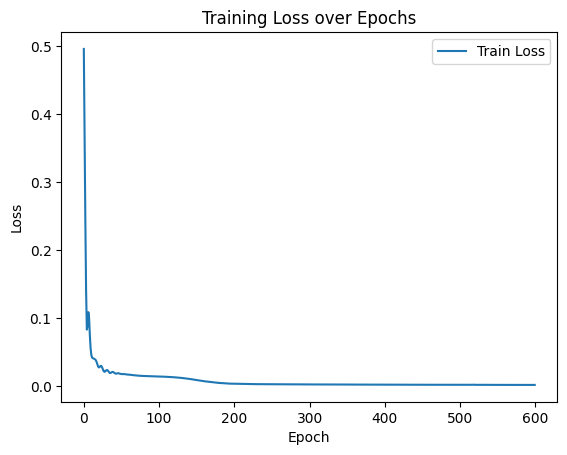

In [18]:
# 绘制损失曲线
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [44]:
# 保存模型
torch.save(model.state_dict(), 'D:/data/0280/lstm_model_3.pth')